In [5]:
from typing import TypedDict, Annotated, List, Literal
import os
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import create_react_agent, ToolNode
from langgraph.checkpoint.memory import MemorySaver

In [6]:
from dotenv import load_dotenv
load_dotenv()

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
os.environ['LANGCHAIN_API_KEY']=os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGSMITH_TRACING']='true'
os.environ['LANGSMITH_PROJECT']='TestProject'
os.environ['TAVILY_API_KEY']=os.getenv('TAVILY_API_KEY')

In [7]:
class AgentState(MessagesState):
    next_agent:str

In [12]:
@tool
def search_web(query:str)->str:
    """Search for web for inofrmation"""
    search = TavilySearchResults(max_results=5)
    res = search.invoke(query)
    return str(res)
    
@tool
def write_summary(summary:str)->str:
    """Write summary of the provided text"""
    
    res = f"Summary of findings:\n\n{summary[:500]}"
    return res

In [13]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm = ChatGroq(model='llama-3.3-70b-versatile')

In [11]:
def research_agent(state:AgentState):
    """Researcher agent researched for the information using taily search"""
    messages=state['messages']
    system_msg = SystemMessage(content="You are are search assistant, use search_web tool to fnd the results")
    
    llm_with_reseach_tool = llm.bind_tools([search_web])
    res = llm_with_reseach_tool.invoke([system_msg]+messages)
    
    return {
        "messages":[res],
        "next_agent":"writer"
    }

In [14]:
def write_agent(state:AgentState):
    """This agent creates the summay"""
    messages = state['messages']
    
    system_msg = SystemMessage(content='You are a techinal writer, Review the conversation and create the summary')
    
    res = llm.invoke([system_msg]+messages)
    
    return {
        "messages":[res],
        "next_agent":"end"            
    }

In [15]:
def execute_tools(state:AgentState):
    """Execute any pending tool calls"""
    messages = state['messages']
    last_msg = messages[-1]
    if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
        tool_node = ToolNode([search_web, write_summary])
        res = tool_node.invoke(state)
        return res

    return state

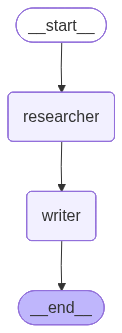

In [18]:
graph = StateGraph(MessagesState)
graph.add_node("researcher",research_agent)
graph.add_node("writer", write_agent)

graph.set_entry_point("researcher")
graph.add_edge("researcher", "writer")
graph.add_edge("writer",END)
graph.compile()

In [19]:
graph=graph.compile()

In [21]:
graph.invoke({"messages":"Reseach on AI, ML?"})["messages"][-1].content

" \n\nHere's a summary of the latest research on AI and ML:\n\n**Recent Advances:**\n\n1. **Explainable AI (XAI)**: Researchers are working on developing techniques to make AI decision-making processes more transparent and interpretable.\n2. **Transfer Learning**: Studies have shown that transfer learning can significantly improve the performance of ML models on new, unseen tasks.\n3. **Adversarial Attacks**: Researchers are exploring ways to defend against adversarial attacks, which can compromise the security of AI systems.\n4. **Reinforcement Learning**: Recent advancements in reinforcement learning have led to breakthroughs in areas like robotics and game playing.\n\n**Emerging Trends:**\n\n1. **Edge AI**: With the increasing use of IoT devices, researchers are focusing on developing AI models that can run efficiently on edge devices.\n2. **Quantum Machine Learning**: The intersection of quantum computing and ML is an exciting area of research, with potential applications in fields